**Dataset: 10k Bone Marrow Mononuclear Cells (BMMNCs), 5' v2.0 (without intronic reads)**

I am performing single-cell RNA sequencing (scRNA-seq) analysis on a dataset of approximately 10,000 bone marrow mononuclear cells (BMMNCs) isolated from a healthy male aged 60-65. The data was generated by 10x Genomics using their Chromium Single Cell 5' Reagent Kits (v2 Chemistry Dual Index) with Feature Barcode technology for Cell Surface Protein and Immune Receptor Mapping

**Citation**

10x Genomics. (2022). Single Cell Immune Profiling Dataset by Cell Ranger 6.1.2 [Data set]. https://www.10xgenomics.com/resources/datasets/bone-marrow-mononuclear-cells-5-v-2-0-without-intronic-reads-10-000-cells-1

In [4]:

!pip install scanpy

# additional packages for scanpy
!pip install leidenalg
!pip install python-igraph
!pip install louvain

# packages for gene set enrichment analysis
!pip install gseapy
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00a 0:00:01


In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gseapy import enrichr, gsea
import anndata
import scipy
import sklearn
import seaborn as sns

In [6]:
# reading the H5 file

adata = sc.read_10x_h5("/kaggle/input/data-dir/10k_BMMNC_5pv2_nextgem_Multiplex_count_raw_feature_bc_matrix.h5")

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique() # This ensures that gene names are unique
adata.obs['n_counts'] = adata.X.sum(axis=1) # Calculate total counts per cell
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1) # Calculate number of genes expressed per cell

In [9]:
# Quality control metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

# Filtering based on QC metrics
sc.pp.filter_cells(adata, min_genes=200)  # filter cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3)  # filter genes found in fewer than 3 cells
adata = adata[adata.obs['n_genes'] < 6000, :] # filter out cells with too many genes



/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [10]:
# Filter out cells with zero counts
adata = adata[adata.X.sum(axis=1).A.squeeze() > 0]

# Optionally, you can also update the observation metadata
adata.obs['n_counts'] = adata.X.sum(axis=1).A.squeeze()
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)

/tmp/ipykernel_34/1939235284.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = adata.X.sum(axis=1).A.squeeze()


In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


In [12]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


In [13]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)  # normalize total counts to 10,000 reads per cell
sc.pp.log1p(adata)  # log-transform the data


... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'pattern' as categorical
... storing 'read' as categorical
... storing 'sequence' as categorical


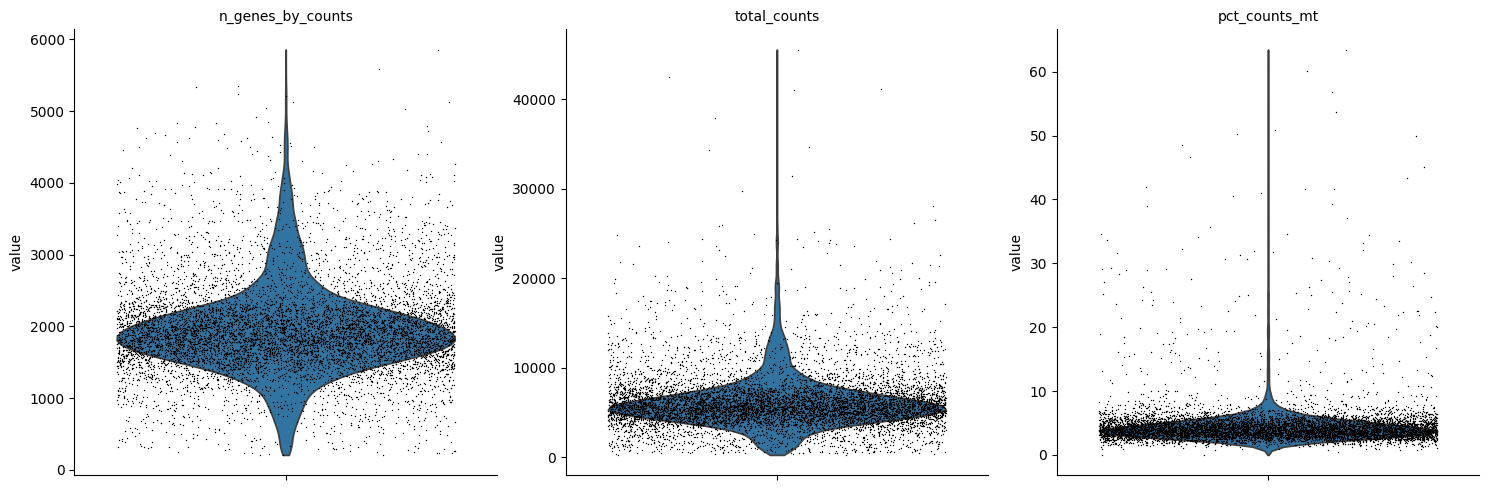

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)


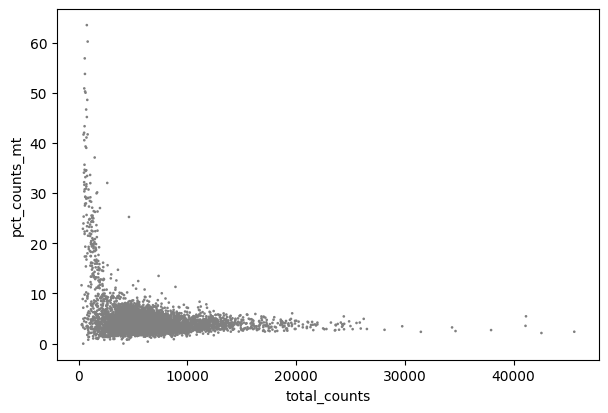

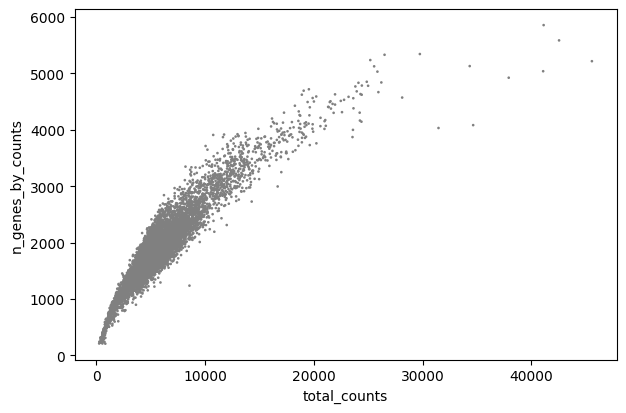

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [16]:
adata

AnnData object with n_obs × n_vars = 8284 × 19165
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'
    uns: 'log1p'

Clustering

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values


In [18]:
adata.raw = adata #saving raw data before processing values and further filtering

In [19]:
adata = adata[:, adata.var.highly_variable] #filter highly variable

In [20]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.pp.scale(adata, max_value=10) #scale each gene to unit variance


In [22]:
sc.tl.pca(adata, svd_solver='arpack')


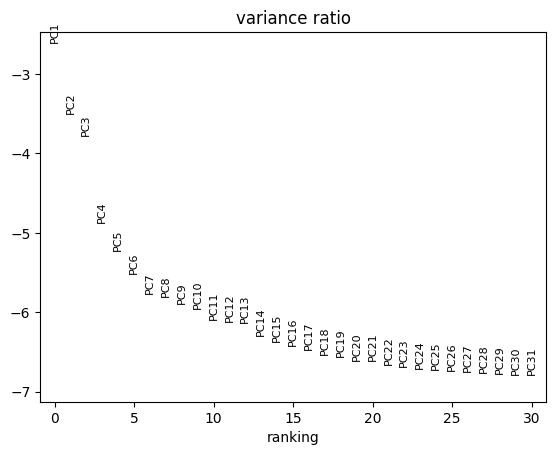

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)


2024-04-24 15:08:39.076924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 15:08:39.077033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 15:08:39.212174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
sc.tl.umap(adata)


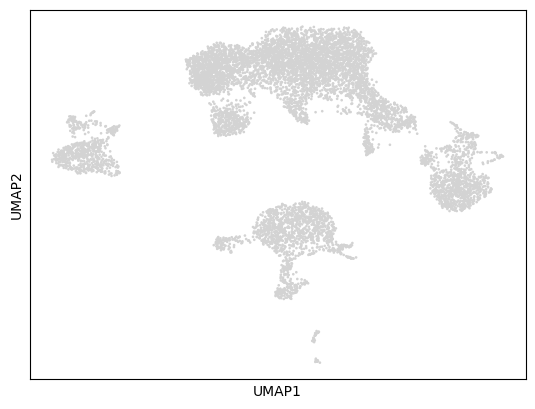

In [26]:
sc.pl.umap(adata)

/tmp/ipykernel_34/3712666207.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.25)


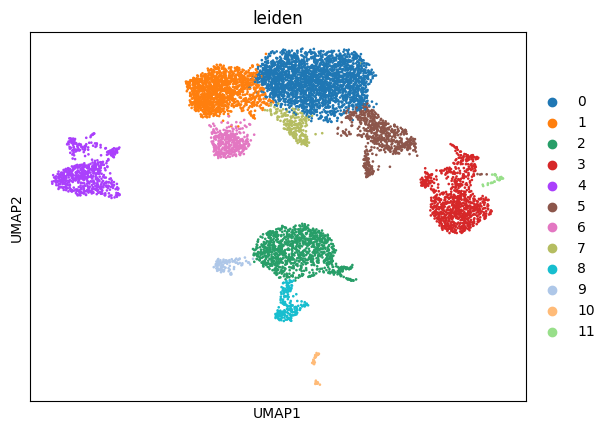

In [27]:
sc.tl.leiden(adata, resolution = 0.25)
sc.pl.umap(adata, color=['leiden'])

Let's find Markers

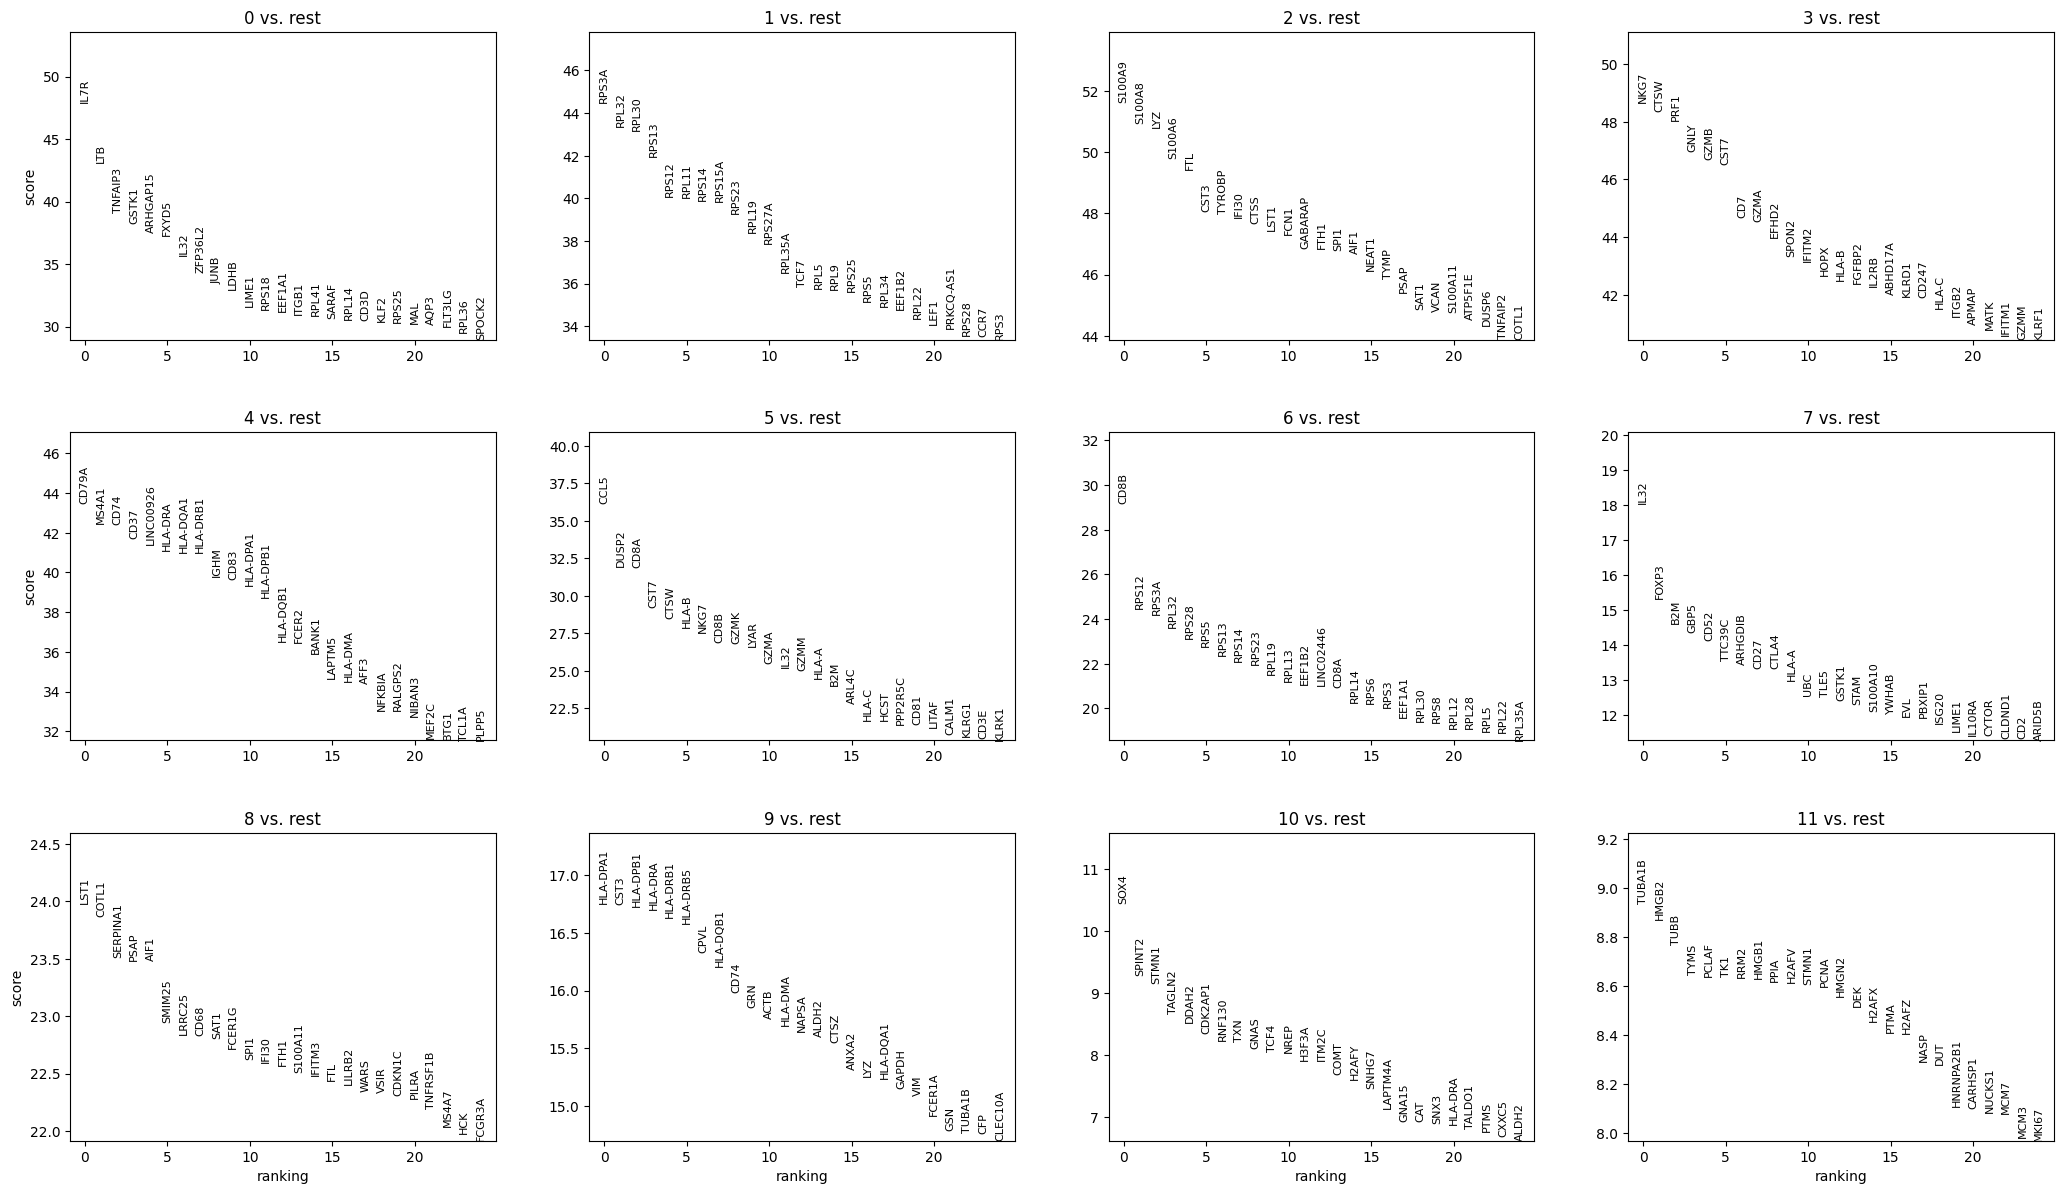

In [28]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [30]:
results = adata.uns['rank_genes_groups']

In [31]:
results['names']['0']

array(['IL7R', 'LTB', 'TNFAIP3', ..., 'CD74', 'HLA-DRB1', 'TYROBP'],
      dtype=object)

In [32]:
#
out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))

In [33]:
out.shape

(229981, 5)

In [34]:
markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])


In [35]:
markers = markers[(markers.pval_adj < 0.05) & (abs(markers.lfc) > 1)]


In [36]:
markers[markers.cluster == '3']


,Gene,scores,pval_adj,lfc,cluster
57495,NKG7,48.655464,0.0,7.570955,3
57496,CTSW,48.368439,0.0,4.821971,3
57497,PRF1,48.047897,0.0,7.091613,3
57498,GNLY,46.962013,0.0,8.777894,3
57499,GZMB,46.679466,0.0,8.011615,3
...,...,...,...,...,...
76654,RPL13,-39.590599,0.0,-1.084469,3
76655,RPL18A,-39.860779,0.0,-1.096667,3
76656,RPS13,-39.927376,0.0,-1.130244,3
76658,RPS8,-40.398724,0.0,-1.199584,3


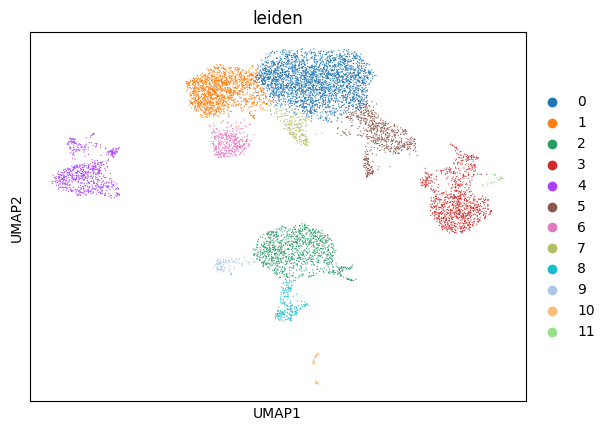

In [40]:
sc.pl.umap(
    adata,
    color=["leiden"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

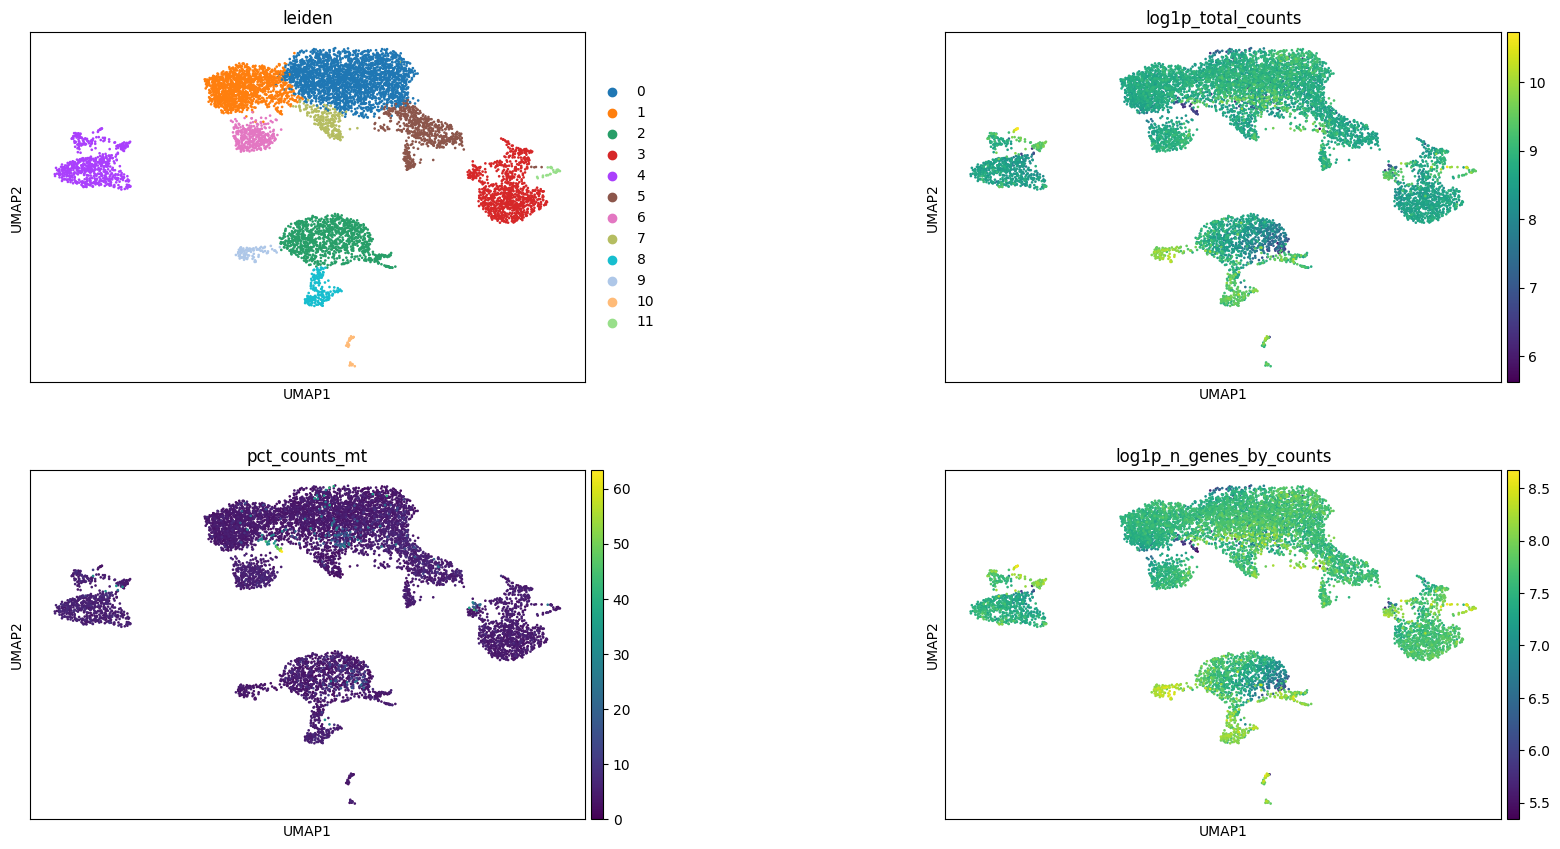

In [41]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

CELL-TYPE ANNOTATION

In [43]:
!pip install celltypist
!pip install decoupler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 46.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 3.9 MB/s eta 0:00:00


In [44]:
import celltypist as ct
import decoupler as dc

In [45]:
# using the Leiden algorithm to extract cell communities from our nearest neighbours graph

sc.tl.leiden(adata, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)

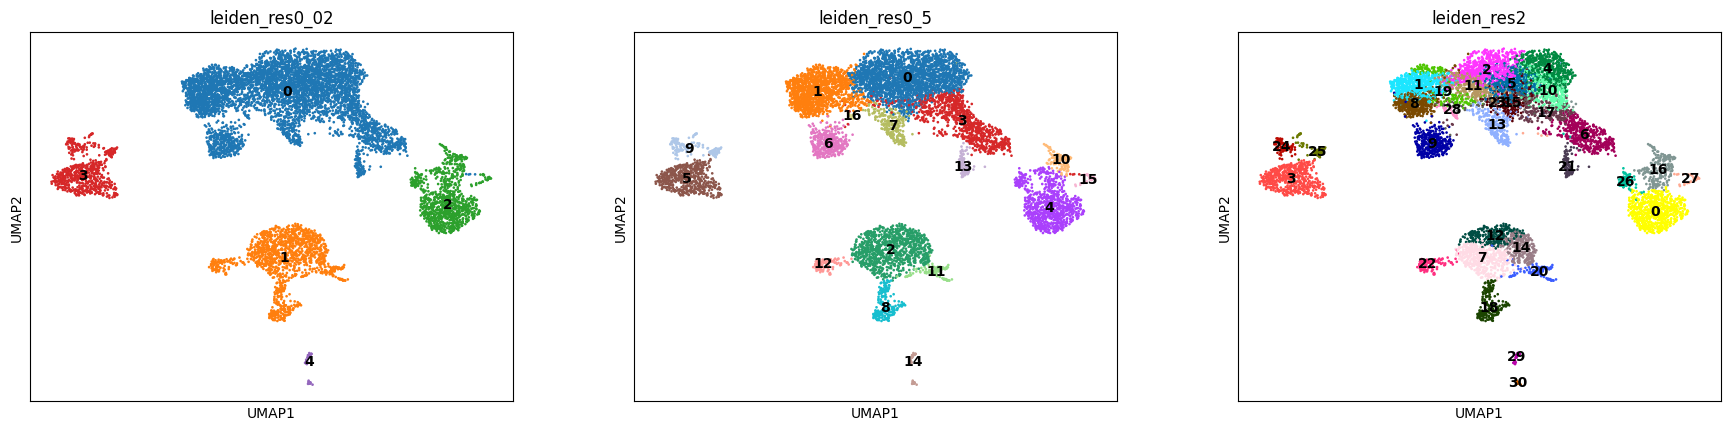

In [46]:
sc.pl.umap(
    adata,
    color=["leiden_res0_02", "leiden_res0_5", "leiden_res2"],
    legend_loc="on data",
)

In [47]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "ID2-hi myeloid prog": [
        "CD14",
        "ID2",
        "VCAN",
        "S100A9",
        "CLEC12A",
        "KLF4",
        "PLAUR",
    ],
    "cDC1": ["CLEC9A", "CADM1"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "GRIK4", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": [
        "VPREB1",
        "MME",
        "EBF1",
        "SSBP2",
        "BACH2",
        "CD79B",
        "IGHM",
        "PAX5",
        "PRKCE",
        "DNTT",
        "IGLL1",
    ],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B1 B": [
        "MS4A1",
        "SSPN",
        "ITGB1",
        "EPHA4",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "CD38",
        "XBP1",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
        "ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],
    "MK/E prog": [
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1",
    ],  # Note PLCB1 is a negative marker
}

In [48]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

In [49]:
adata.layers["counts"] = adata.X
adata.X = adata.layers["scran_normalization"]

KeyError: 'scran_normalization'